# Multi-Layer QG (Revised)

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def dstI1D(x, norm="ortho"):
    """1D type-I discrete sine transform."""

    num_dims = x.ndim
    N = x.shape
    padding = ((0,0),) * (num_dims-1) + ((1,1),) 
    x = jnp.pad(x, pad_width=padding, mode="constant", constant_values=0.0)
    x = jnp.fft.irfft(-1j * x, axis=-1, norm=norm)
    x = jax.lax.slice_in_dim(x, 1, N[-1]+1, axis=-1)
    return x

def dstI2D(x, norm="ortho"):
    """2D type-I discrete sine transform."""
    x = dstI1D(x, norm=norm)
    x = jnp.transpose(x, axes=(-1,-2))
    x = dstI1D(x, norm=norm)
    x = jnp.transpose(x, axes=(-1,-2))
    return x


def inverse_elliptic_dst(f, operator_dst):
    """Inverse elliptic operator (e.g. Laplace, Helmoltz)
    using float32 discrete sine transform."""
    num_dims = f.ndim
    padding = ((0,0),) * (num_dims-2) + ((1,1),(1,1)) 
    x = dstI2D(f) / operator_dst
    print(x)
    
    return jnp.pad(dstI2D(x), pad_width=padding, mode="constant", constant_values=0.0)

In [3]:
# def solve_helmholtz_dst(rhs, helmholtz_dst):
#     x = dstI2D_torch(rhs.type(helmholtz_dst.dtype)) / helmholtz_dst
#     return F.pad(dstI2D_torch(x),
#                  (1,1,1,1)
#                 ).type(torch.float64)

## Helmholtz Decomposition

In [4]:
N = 8
nx, ny = 2*2**(N-1), 2*2**(N-1)
shape = (nx, ny)

L = 2_000e3

xc = jnp.linspace(-L, L, nx+1)
yc = jnp.linspace(-L, L, ny+1)

xx, yy = jnp.meshgrid(xc, yc, indexing="ij")

dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

xx.shape

(257, 257)

**Helmholtz Equation**

In [5]:
# from jaxsw._src.operators.functional.dst import helmholtz_dist, laplacian_dist, inverse_elliptical_dst_solver, inverse_elliptic_dst

In [6]:
def laplacian_dist(nx, ny, dx, dy, mean: bool = True) -> Array:
    if mean:
        dx = dy = jnp.mean(jnp.asarray([dx, dy]))

    x, y = jnp.meshgrid(
        jnp.arange(1, nx, dtype=dx.dtype),
        jnp.arange(1, ny, dtype=dx.dtype),
        indexing="ij"
    )

    return (
        2 * (jnp.cos(jnp.pi / nx * x) - 1) / dx**2
        + 2 * (jnp.cos(jnp.pi / ny * y) - 1) / dy**2
    )

In [7]:
def helmholtz_fn(u, dx, dy, beta):
    d2u_dx2 = (u[...,2:,1:-1] + u[...,:-2,1:-1] - 2*u[..., 1:-1,1:-1]) / dx**2
    d2u_dy2 = (u[...,1:-1,2:] + u[...,1:-1,:-2] - 2*u[...,1:-1,1:-1]) / dy**2
    return d2u_dx2 + d2u_dy2 - beta * u[..., 1:-1,1:-1]

In [8]:
beta = 0.0

H_matrix = laplacian_dist(nx, ny, dx, dy) - beta

print(H_matrix.shape, xx.shape)

(255, 255) (257, 257)


In [9]:
# create random matrix
key = jrandom.PRNGKey(42)
Frect = jnp.zeros(shape=(nx+1,ny+1))
Frect = Frect.at[1:-1,1:-1].set(jrandom.normal(key=key, shape=(nx-1,ny-1)))

Frect.shape

(257, 257)

In [10]:

Hfrect = helmholtz_fn(Frect, dx, dy, beta)
Hfrect.shape

(255, 255)

## Solve

In [11]:
Frect_r = inverse_elliptic_dst(Hfrect, H_matrix)

[[ 0.05501007 -0.03542188  1.17595465 ... -0.28358731  2.30316289
  -1.55308384]
 [ 0.13221757 -0.17921672 -0.0100907  ... -0.85739685  0.92190009
   0.44759665]
 [ 0.63621956  1.74382069 -0.43647494 ...  0.52664042 -0.53811008
   0.99754976]
 ...
 [ 0.77379742  0.01429062 -0.94020866 ... -1.12535295 -0.09042252
   0.5699737 ]
 [ 1.12227745 -0.42621788 -1.35599735 ... -0.02761096 -0.22009151
   0.35001407]
 [-1.06695801  0.50787638  1.0419386  ...  0.32819906  1.55285075
  -0.64286374]]


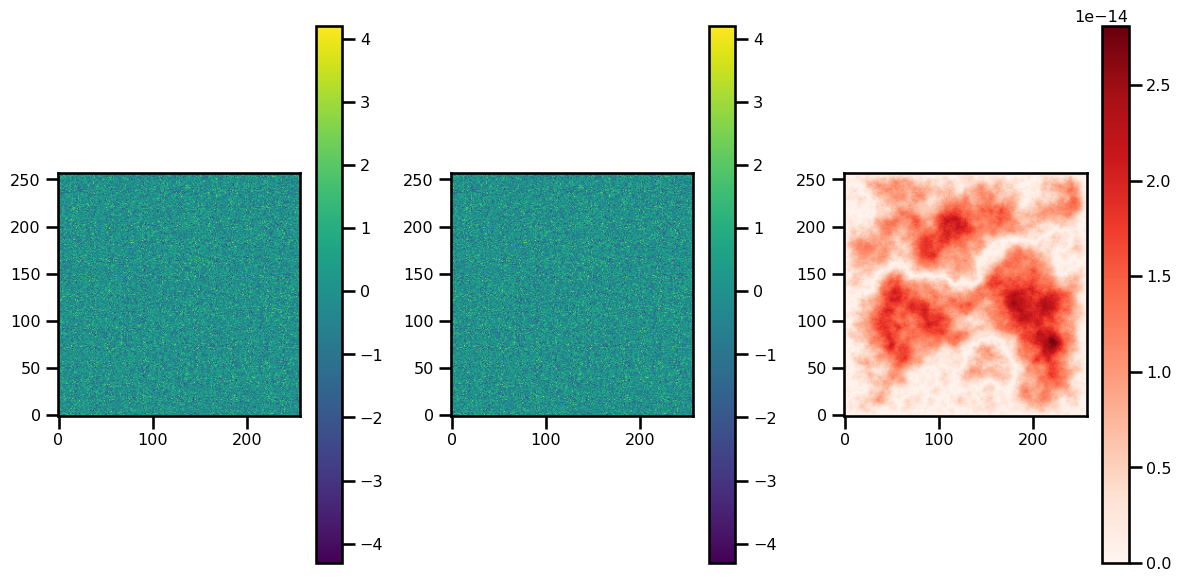

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6))

pts = ax[0].imshow(Frect.T, origin="lower")
plt.colorbar(pts)

pts = ax[1].imshow(Frect_r.T, origin="lower")
plt.colorbar(pts)

pts = ax[2].imshow(np.abs(Frect - Frect_r).T, origin="lower", cmap="Reds")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## TORCH CODE

In [90]:
import torch
import torch.nn.functional as F


def dstI1D_torch(x, norm='ortho'):
    """1D type-I discrete sine transform."""
    return torch.fft.irfft(-1j*F.pad(x, (1,1)), dim=-1, norm=norm)[...,1:x.shape[-1]+1]


def dstI2D_torch(x, norm="ortho"):
    """2D type-I discrete sine transform."""
    return dstI1D_torch(dstI1D_torch(x, norm=norm).transpose(-1,-2), norm=norm).transpose(-1,-2)


def compute_laplace_dst(nx, ny, dx, dy, arr_kwargs):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = torch.meshgrid(torch.arange(1,nx, **arr_kwargs),
                          torch.arange(1,ny, **arr_kwargs),
                          indexing='ij')
    return 2*(torch.cos(torch.pi/nx*x) - 1)/dx**2 + 2*(torch.cos(torch.pi/ny*y) - 1)/dy**2


def solve_helmholtz_dst(rhs, helmholtz_dst):
    return F.pad(dstI2D_torch(dstI2D_torch(rhs.type(helmholtz_dst.dtype)) / helmholtz_dst),
                 (1,1,1,1)
                ).type(torch.float64)


In [91]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 24})
plt.ion()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float64

# grid
N = 8
nx, ny = 2*2**(N-1), 2*2**(N-1)
shape = (nx, ny)
L = 2000e3
xc = torch.linspace(-L, L, nx+1, dtype=dtype, device=device)
yc = torch.linspace(-L, L, ny+1, dtype=dtype, device=device)
xx, yy = torch.meshgrid(xc, yc, indexing='ij')
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

print(xx.shape)

# Helmholtz eq.
lambd = torch.DoubleTensor(1,1,1).type(dtype).to(device)
helmholtz = lambda f, dx, dy, lambd: \
    (   (f[...,2:,1:-1] + f[...,:-2,1:-1] - 2*f[...,1:-1,1:-1])/dx**2
      + (f[...,1:-1,2:] + f[...,1:-1,:-2] - 2*f[...,1:-1,1:-1])/dy**2
      - lambd * f[...,1:-1,1:-1]
    )
helmholtz_dst = compute_laplace_dst(
        nx, ny, dx, dy, {'dtype':dtype, 'device': device}) \
        - lambd

torch.Size([257, 257])


In [92]:
np.testing.assert_array_almost_equal(H_matrix, helmholtz_dst[0].numpy())

In [93]:
frect_ = torch.Tensor(np.asarray(Frect))

In [94]:
# Rectangular domain
# frect = torch.zeros(1, nx+1, ny+1, dtype=dtype, device=device)
# frect[...,1:-1,1:-1].normal_()
frect_torch = torch.Tensor(np.asarray(Frect))
Hfrect_torch = helmholtz(frect_torch, dx, dy, lambd)

In [95]:
np.testing.assert_array_almost_equal(Hfrect, Hfrect_torch[0].numpy())

In [96]:
helmholtz_dst

tensor([[[-1.2337e-12, -3.0841e-12, -6.1679e-12,  ..., -1.6379e-08,
          -1.6382e-08, -1.6384e-08],
         [-3.0841e-12, -4.9346e-12, -8.0183e-12,  ..., -1.6381e-08,
          -1.6384e-08, -1.6386e-08],
         [-6.1679e-12, -8.0183e-12, -1.1102e-11,  ..., -1.6384e-08,
          -1.6387e-08, -1.6389e-08],
         ...,
         [-1.6379e-08, -1.6381e-08, -1.6384e-08,  ..., -3.2757e-08,
          -3.2760e-08, -3.2762e-08],
         [-1.6382e-08, -1.6384e-08, -1.6387e-08,  ..., -3.2760e-08,
          -3.2763e-08, -3.2765e-08],
         [-1.6384e-08, -1.6386e-08, -1.6389e-08,  ..., -3.2762e-08,
          -3.2765e-08, -3.2767e-08]]], dtype=torch.float64)

In [97]:
frect_r_torch = solve_helmholtz_dst(Hfrect_torch, helmholtz_dst)

In [112]:
np.testing.assert_array_almost_equal(Frect_r, frect_r_torch[0].numpy())

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 65025 / 66049 (98.4%)
Max absolute difference: 6.87002811e+09
Max relative difference: 5.18404634e+13
 x: array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  5.324457e+07,  1.655710e+08, ..., -2.871165e+08,...
 y: array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00, -2.621758e-01, -1.509387e+00, ...,  2.014655e+00,...

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_19858/1765908596.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  fig.colorbar(ax[1].imshow(torch.abs(frect_torch - frect_r_torch).cpu().T, origin='lower'), ax=ax[1])


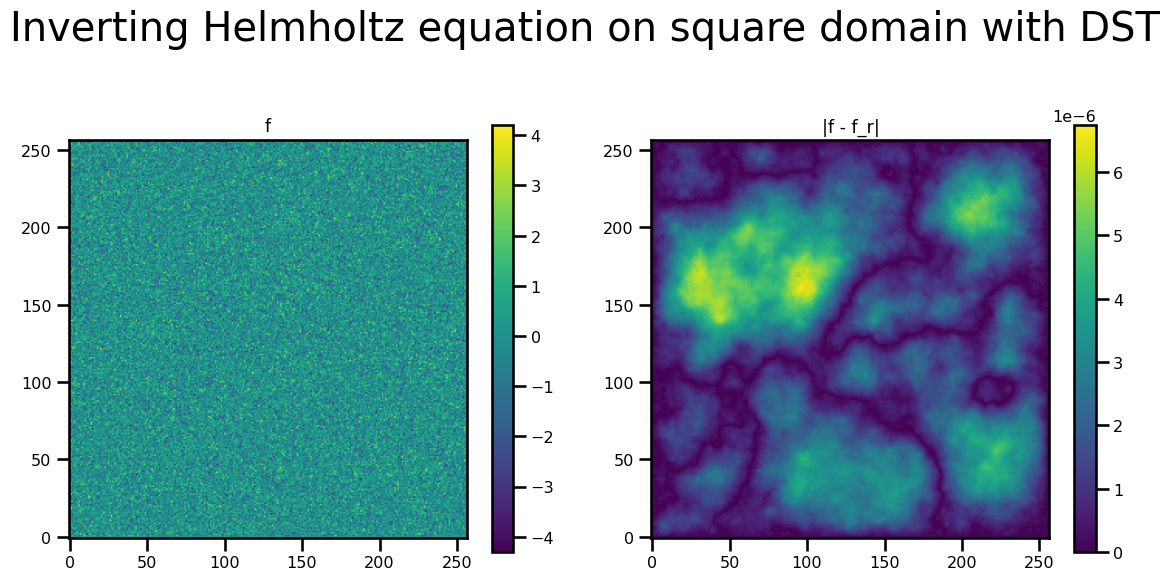

In [98]:


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].set_title('f')
fig.colorbar(ax[0].imshow(frect_torch.cpu().T, origin='lower'), ax=ax[0])
ax[1].set_title('|f - f_r|')
fig.colorbar(ax[1].imshow(torch.abs(frect_torch - frect_r_torch).cpu().T, origin='lower'), ax=ax[1])
fig.suptitle('Inverting Helmholtz equation on square domain with DST')
fig.tight_layout()